In [1]:
import json
from pprint import pprint
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.cluster import DBSCAN

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
restaurants = []
with open('I:/yelp_dataset/restaurant_data/restaurant.json', encoding='utf-8') as f:
    for line in f:
        restaurant = json.loads(line)
        restaurant['categories'] = [x.strip() for x in restaurant['categories'].split(',')]
        restaurants.append(restaurant)

In [3]:
italian_restaurants = [x for x in restaurants if 'Italian' in x['categories']]
other_restaurants = [x for x in restaurants if 'Italian' not in x['categories']]

In [4]:
categories = set()
for restaurant in restaurants:
    for category in restaurant['categories']:
        categories.add(category)
print(len(categories))

811


In [28]:
with open('I:/yelp_dataset/restaurant_data/categories.json', mode='w') as f:
    json.dump(list(categories), f)

In [5]:
def restaurant_to_row(restaurant, categories):
    row = {i: 0 for i in categories}
    row['business_id'] = restaurant['business_id']
    for category in restaurant['categories']:
        row[category] = 1
    return row

In [6]:
other_restaurant_rows = [restaurant_to_row(x, categories) for x in other_restaurants]

In [7]:
df = pd.DataFrame(other_restaurant_rows)
X = df.drop('business_id', axis=1)

In [8]:
# CAUTION! This step may take several hours
model = DBSCAN(eps=1, metric='l2')
model.fit(df.drop('business_id', axis=1))

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='l2', metric_params=None,
       min_samples=5, n_jobs=None, p=None)

In [30]:
len(model.components_)

49476

In [9]:
pd.Series(model.labels_).value_counts()

 0     51201
-1      6712
 1       531
 8        96
 7        44
 2        35
 11       34
 12       32
 17       23
 3        19
 9        18
 6        16
 10       14
 20       12
 25       12
 27       12
 22        9
 15        9
 13        9
 5         9
 23        8
 4         8
 34        8
 31        7
 18        7
 19        7
 21        7
 29        7
 33        6
 30        6
 14        6
 16        5
 24        5
 26        5
 28        5
 32        5
dtype: int64

In [10]:
labeled_df = df.drop('Restaurants', axis=1)
labeled_df['label'] = model.labels_ + 1
labeled_df

,Mobile Phones,Hair Removal,Shared Office Spaces,Wine Tasting Room,Farms,Halal,Security Services,Music Venues,Gastropubs,Surf Schools,...,Italian,Irrigation,Employment Agencies,Fitness & Instruction,Comfort Food,Hats,Brazilian Jiu-jitsu,Colleges & Universities,business_id,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,pQeaRpvuhoEqudo3uymHIQ,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,CsLQLiRoafpJPJSkNX2h5Q,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,eBEfgOPG7pvFhb2wcG9I7w,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,lu7vtrp_bE9PnxWfA8g4Pg,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9sRGfSVEfLhN_km60YruTA,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,xVpE01l6ZXdEtVf5PkRpDg,1
58945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BAVuLTDmpSzDCk37A5HjtQ,1
58946,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,hskVqZCPqy-omm9CHi44xQ,1
58947,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9Q0fPWAjUweoFDk0kafuzQ,1


In [34]:
labeled_df[['business_id', 'label']].to_json('I:/yelp_dataset/restaurant_data/business_clusters.json', orient='records')

In [11]:
vectors = labeled_df.groupby('label').mean()
counts = labeled_df.groupby('label')['label'].count()

for cluster in range(labeled_df['label'].max()):
    print(f'\nCluster {cluster}, count: {counts[cluster]}')
    temp_df = vectors.transpose()[cluster].sort_values(ascending=False)
    identifying_categories = temp_df[temp_df > 0.9]
    [print(x) for x in identifying_categories.index] if len(identifying_categories > 0) else print('()')
    print('\n')
    print(vectors.transpose()[cluster].sort_values(ascending=False).head())
    print('\n' + '-'*40)


Cluster 0, count: 6712
()


Food                         0.570918
Nightlife                    0.362485
Bars                         0.333731
Event Planning & Services    0.188468
American (Traditional)       0.171633
Name: 0, dtype: float64

----------------------------------------

Cluster 1, count: 51201
()


Food                      0.215074
Fast Food                 0.147595
Sandwiches                0.122419
American (Traditional)    0.115213
Nightlife                 0.111013
Name: 1, dtype: float64

----------------------------------------

Cluster 2, count: 531
Beer
Wine & Spirits
Food


Beer              1.000000
Wine & Spirits    1.000000
Food              1.000000
Nightlife         0.647834
Bars              0.638418
Name: 2, dtype: float64

----------------------------------------

Cluster 3, count: 35
Gas Stations
Food
Convenience Stores
Automotive


Gas Stations          1.000000
Food                  1.000000
Convenience Stores    1.000000
Automotive            1.0000

Name: 29, dtype: float64

----------------------------------------

Cluster 30, count: 7
Arts & Entertainment
Bars
Nightlife
Cinema


Arts & Entertainment    1.000000
Bars                    1.000000
Nightlife               1.000000
Cinema                  1.000000
Dinner Theater          0.428571
Name: 30, dtype: float64

----------------------------------------

Cluster 31, count: 6
American (New)
Fast Food
Cheesesteaks
Hot Dogs


American (New)        1.000000
Fast Food             1.000000
Cheesesteaks          1.000000
Hot Dogs              1.000000
Breakfast & Brunch    0.333333
Name: 31, dtype: float64

----------------------------------------

Cluster 32, count: 7
Bars
Beer Bar
Nightlife
Juice Bars & Smoothies
Burgers
Food
Cocktail Bars
American (New)


Bars                      1.0
Beer Bar                  1.0
Nightlife                 1.0
Juice Bars & Smoothies    1.0
Burgers                   1.0
Name: 32, dtype: float64

----------------------------------------

Cluster 33

In [12]:
reviews = []
with open('I:/yelp_dataset/restaurant_data/review.json', encoding='utf-8') as f:
    for line in f:
        reviews = json.loads(line)

In [13]:
df2 = pd.DataFrame(reviews[:-1]).merge(labeled_df[['business_id','label']], on='business_id', how='left')
df2['label'] = df2['label'].fillna(-1)

In [14]:
italian_restaurant_reviewers = df2[df2['label'] == -1].groupby('user_id').count()['label']
top_italian_restaurant_reviewers = italian_restaurant_reviewers[italian_restaurant_reviewers >= 5]
top_italian_restaurant_reviewers

user_id
---1lKK3aKOuomHnwAkAow    14
--2HUmLkcNHZp0xw6AMBPg    11
--Qh8yKWAvIP4V4K8ZPfHA    26
--cd_gA-9Q8gM9P2cTxEsQ     6
-0aInSHjCWLfiNqfgmWnow     5
                          ..
zyg4-MFtfPWmwucVazSjfw     6
zyjsU8rV-q-Wq7wFksVyJw    12
zynfOy36AZ0WsoGUYAjQaA     6
zzPvEodjvLPe-5NvV0U_cg    15
zzgb9L3NBT9V8BGw_DcVYw     6
Name: label, Length: 12614, dtype: int64

In [15]:
italian_restaurant_ids = set([x['business_id'] for x in italian_restaurants])
italian_restaurant_reviewer_ids = [x['user_id'] for x in reviews[:-1] if x['business_id'] in italian_restaurant_ids]

In [16]:
df3 = df2[df2['user_id'].isin(top_italian_restaurant_reviewers.index)].groupby(['user_id', 'label']).mean().reset_index().set_index('user_id').pivot(columns='label', values='stars')
df3

label,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,3.142857,4.142857,3.731707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--2HUmLkcNHZp0xw6AMBPg,4.545455,4.950000,4.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--Qh8yKWAvIP4V4K8ZPfHA,3.115385,3.472222,2.982353,3.2,NaN,3.0,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--cd_gA-9Q8gM9P2cTxEsQ,4.166667,4.142857,4.172414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0aInSHjCWLfiNqfgmWnow,4.600000,4.200000,3.975610,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zyg4-MFtfPWmwucVazSjfw,3.166667,2.875000,3.528846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zyjsU8rV-q-Wq7wFksVyJw,4.416667,4.000000,4.071429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zynfOy36AZ0WsoGUYAjQaA,3.500000,3.500000,3.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
linreg = LinearRegression()
X = df3.drop(-1, axis=1).fillna(3)
y = df3[-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
linreg.fit(X_train, y_train)
linreg.score(X_test, y_test)

0.3783990841387065

In [19]:
mean_absolute_error(y_test, linreg.predict(X_test))

0.38988373741823273

In [20]:
r2_score(y_test, linreg.predict(X_test))

0.3783990841387065

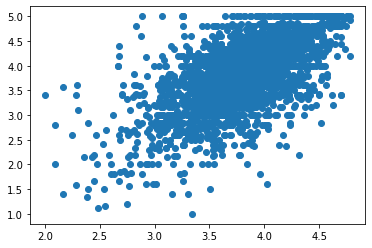

In [21]:
plt.scatter(linreg.predict(X_test), y_test)

In [22]:
from joblib import dump

In [24]:
dump(model, 'I:/yelp_dataset/restaurant_data/dbscan.joblib')

['I:/yelp_dataset/restaurant_data/dbscan.joblib']

In [25]:
dump(linreg, 'I:/yelp_dataset/restaurant_data/linreg.joblib')

['I:/yelp_dataset/restaurant_data/linreg.joblib']